# Safety Filtering Demonstration

This notebook demonstrates the safety filtering capabilities of the reachability-based approach. It:
1. Loads a pretrained world model and safety filter
2. Uses a recorded failure episode as a base policy
3. Applies safety filtering to prevent unsafe actions
4. Visualizes the results with green boundaries when filtering occurs

## Setup and Imports


In [1]:
import os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Image, display
import gymnasium as gym 
from pathlib import Path
import ruamel.yaml as yaml
from collections import defaultdict
import cv2
from PIL import Image as PILImage
import io
import argparse

# Add paths for Isaac Lab and latent_safety
sys.path.append('latent_safety')

# Set environment variables for Isaac Lab Jupyter compatibility
os.environ["ISAAC_JUPYTER_KERNEL"] = "1"

# Set up command line arguments for Isaac Lab
import argparse
launcher_args = argparse.Namespace()
launcher_args.headless = True
launcher_args.enable_cameras = True
launcher_args.disable_fabric = False

print("✅ Basic imports and setup complete!")
print("✅ Isaac Lab Jupyter environment configured")


✅ Basic imports and setup complete!
✅ Isaac Lab Jupyter environment configured


In [ ]:
# Launch Isaac Lab simulation app for Jupyter notebook
try:
    from omni.isaac.lab.app import AppLauncher
    
    # Create app launcher with headless configuration for notebook
    app_launcher = AppLauncher(launcher_args)
    simulation_app = app_launcher.app
    
    print("✅ Isaac Lab simulation app launched for Jupyter notebook")
    print(f"  Headless: {launcher_args.headless}")
    # print(f"  Enable cameras: {launcher_args.enable_cameras}")
    
except Exception as e:
    print(f"❌ Error launching Isaac Lab: {e}")
    simulation_app = None


[INFO][AppLauncher]: Loading experience file: /home/junwon/Isaac/IsaacLab/source/apps/isaaclab.python.headless.rendering.kit
[Warning] [omni.isaac.kit.simulation_app] fast shutdown not supported with jupyter notebooks
Loading user config located at: '/home/junwon/.local/share/ov/pkg/isaac-sim-4.2.0/kit/data/Kit/Isaac-Sim/4.2/user.config.json'
[Info] [carb] Logging to file: /home/junwon/.local/share/ov/pkg/isaac-sim-4.2.0/kit/logs/Kit/Isaac-Sim/4.2/kit_20250922_222333.log
2025-09-23 02:23:33 s] [Warning] [omni.kit.app.plugin] No crash reporter present, dumps uploading isn't available.
2025-09-23 02:23:33 s] [Warning] [carb.windowing-glfw.plugin] GLFW initialization failed.
2025-09-23 02:23:33 s] [Warning] [carb] Failed to startup plugin carb.windowing-glfw.plugin (interfaces: [carb::windowing::IGLContext v1.0],[carb::windowing::IWindowing v1.4]) (impl: carb.windowing-glfw.plugin)
2025-09-23 02:23:33 s] [Warning] [omni.platforminfo.plugin] failed to open the default display.  Can't verif

2025-09-23 02:23:33 s] [Error] [carb.glinterop.plugin] GLInteropContext::init: carb::windowing is not available



|---------------------------------------------------------------------------------------------|
| Driver Version: 560.35.05     | Graphics API: Vulkan
|=============================================================================================|
| GPU | Name                             | Active | LDA | GPU Memory | Vendor-ID | LUID       |
|     |                                  |        |     |            | Device-ID | UUID       |
|     |                                  |        |     |            | Bus-ID    |            |
|---------------------------------------------------------------------------------------------|
| 0   | NVIDIA GeForce RTX 4090          | Yes: 0 |     | 24810   MB | 10de      | 0          |
|     |                                  |        |     |            | 2684      | 13ce91d8.. |
|     |                                  |        |     |            | 1         |            |
|-------------------------------------------------------------------------------

✅ Isaac Lab simulation app launched for Jupyter notebook
  Headless: True
[INFO] Simulation app already running - skipping duplicate launch
✅ All dreamer and reachability components imported successfully!
✅ Complete configuration loaded with all required parameters!
  Device: cuda
  Total config parameters: 119
Setting up environment: Isaac-Takeoff-Franka-IK-Rel-v0
  Headless: True
  Enable cameras: True
  Device: cuda
[INFO]: Parsing configuration from: <class 'takeoff.config.franka.takeoff_ik_rel_env_cfg.FrankaTakeoffEnvCfg'>
[INFO]: Base environment:
	Environment device    : cuda:0
	Environment seed      : 0
	Physics step-size     : 0.01
	Rendering step-size   : 0.05
	Environment step-size : 0.05
[INFO]: Time taken for scene creation : 0.799167 seconds
[INFO]: Scene manager:  <class InteractiveScene>
	Number of environments: 1
	Environment spacing   : 2.5
	Source prim name      : /World/envs/env_0
	Global prim paths     : []
	Replicate physics     : False
[INFO]: Starting the simula

In [3]:
# Import remaining components
try:
    # Import dreamer and reachability components
    import dreamerv3_torch.dreamer as dreamer
    import dreamerv3_torch.tools as tools
    import dreamerv3_torch.envs.wrappers as wrappers
    from dreamer_wrapper import DreamerVecEnvWrapper
    from reachability.policy.SAC_Reachability_Env import SAC
    from omni.isaac.lab_tasks.utils import parse_env_cfg
    from takeoff import mdp
    from takeoff.config import franka
    
    print("✅ All dreamer and reachability components imported successfully!")
    
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("Please ensure all required modules are available")
except Exception as e:
    print(f"❌ Unexpected error during imports: {e}")
    print("Please check your environment setup")


/home/junwon/Isaac/IsaacLab/_isaac_sim/exts/omni.isaac.ml_archive/pip_prebundle/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment Isaac-Stack-Cube-Franka-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/junwon/Isaac/IsaacLab/_isaac_sim/exts/omni.isaac.ml_archive/pip_prebundle/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment Isaac-Stack-Cube-Instance-Randomize-Franka-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/junwon/Isaac/IsaacLab/_isaac_sim/exts/omni.isaac.ml_archive/pip_prebundle/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment Isaac-Stack-Cube-Franka-IK-Rel-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/junwon/Isaac/IsaacLab/_isaac_sim/exts/omni.isaac.ml_archive/pip_prebundle/gymnasium/envs/registration.py:694: UserWarning:

## Configuration and Setup


In [ ]:
# Updated Configuration with all required parameters
class ConfigComplete:
    """Config class that supports both attribute access and 'in' operator for dictionary-like behavior"""
    def __init__(self):
        # Model paths
        self.model_path = "log/dreamer.pt"
        self.reachability_model_path = "log/reachability/filter"
        self.failure_episode_path = "log/failure_1.npz" # FIXME: path to npz file with recorded episodes
        
        # Environment settings - Isaac Lab specific
        self.task = "Isaac-Takeoff-Franka-IK-Rel-v0"
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.headless = True
        self.enable_cameras = True
        self.disable_fabric = False
        self.num_envs = 1
        self.size = [128, 128]  # Image size
        self.envs = 1
        self.action_repeat = 2
        self.time_limit = 1000
        self.grayscale = False
        self.prefill = 2500
        self.reward_EMA = True
        
        # Model parameters (from dreamer config)
        self.dyn_stoch = 32
        self.dyn_deter = 512
        self.dyn_discrete = 32
        self.dyn_hidden = 512
        self.dyn_rec_depth = 1
        self.dyn_mean_act = 'none'
        self.dyn_std_act = 'sigmoid2'
        self.dyn_min_std = 0.1
        self.control_net = [512, 512, 512, 512]
        self.critic_net = [512, 512, 512, 512]
        self.ood_threshold = 4.0
        self.num_actions = 7  # Will be updated from environment
        self.units = 512
        self.act = 'SiLU'
        self.norm = True
        self.use_uq = True
        self.use_ensemble = True
        self.use_unit_ensemble = False
        self.use_nf = False
        
        # Training parameters needed for model loading
        self.batch_size = 16
        self.batch_length = 16
        self.train_ratio = 512
        self.pretrain = 100
        self.model_lr = 1e-4
        self.opt_eps = 1e-8
        self.grad_clip = 1000
        self.dataset_size = 1000000
        self.opt = "adam"
        self.weight_decay = 0.0
        self.use_amp = False
        self.log_every = 50
        self.compile = True
        self.precision = 32
        self.debug = False
        self.video_pred_log = True
        
        # RL parameters
        self.maxUpdates = 200000
        self.memoryCapacity = 500000
        self.checkPeriod = 10000
        self.tau = 0.005
        self.actor_lr = 1e-4
        self.critic_lr = 1e-4
        self.action_reg = False
        self.model_free = False
        self.rand_action = False
        
        # Reachability specific parameters
        self.reachability_batch_size = 512
        self.gamma_reachability = 0.95
        self.stochastic_l = False
        
        # Behavior parameters
        self.discount = 0.997
        self.discount_lambda = 0.95
        self.imag_horizon = 15
        self.imag_gradient = 'dynamics'
        self.imag_gradient_mix = 0.0
        self.eval_state_mean = False
        
        # Exploration parameters
        self.expl_behavior = 'greedy'
        self.expl_until = 0
        self.expl_extr_scale = 0.0
        self.expl_intr_scale = 1.0
        self.disag_target = 'deter'
        self.disag_log = True
        self.disag_models = 5
        self.disag_offset = 1
        self.disag_layers = 4
        self.disag_units = 400
        self.disag_action_cond = True
        
        # Evaluation parameters
        self.eval_every = 500
        self.eval_num_seeds = 50
        self.eval_per_seed = 1
        self.eval_episodes = 100
        self.eval_render = False
        self.eval_save_video = False
        
        # Logging parameters
        self.logdir = "latent_safety/log/reachability"
        self.traindir = None
        self.evaldir = None
        self.offline_traindir = None
        self.offline_evaldir = ''
        self.seed = 0
        self.deterministic_run = True
        self.steps = 1e6
        self.parallel = False
        self.reset_every = 0
        self.from_ckpt = None
        self.lx_ckpt = None
        self.from_prefill_dir = None
        self.obs_step = 1
        
        # Model head configurations
        self.grad_heads = ['decoder', 'reward', 'cont', 'failure']
        self.encoder = {
            'mlp_keys': '^eef_(pos|quat)$', 
            'cnn_keys': '.*\_cam$', 
            'act': 'SiLU', 
            'norm': True, 
            'cnn_depth': 32, 
            'kernel_size': 4, 
            'minres': 4, 
            'mlp_layers': 5, 
            'mlp_units': 1024, 
            'symlog_inputs': True
        }
        self.decoder = {
            'mlp_keys': '^eef_(pos|quat)$', 
            'cnn_keys': '.*\_cam$', 
            'act': 'SiLU', 
            'norm': True, 
            'cnn_depth': 32, 
            'kernel_size': 4, 
            'minres': 4, 
            'mlp_layers': 5, 
            'mlp_units': 1024, 
            'cnn_sigmoid': False, 
            'image_dist': 'mse', 
            'vector_dist': 'symlog_mse', 
            'outscale': 1.0
        }
        self.actor = {
            'layers': 2, 
            'dist': 'normal', 
            'entropy': 3e-4, 
            'unimix_ratio': 0.01, 
            'std': 'learned', 
            'min_std': 0.1, 
            'max_std': 1.0, 
            'temp': 0.1, 
            'lr': 3e-5, 
            'eps': 1e-5, 
            'grad_clip': 100.0, 
            'outscale': 1.0
        }
        self.critic = {
            'layers': 2, 
            'dist': 'symlog_disc', 
            'slow_target': True, 
            'slow_target_update': 1, 
            'slow_target_fraction': 0.02, 
            'lr': 3e-5, 
            'eps': 1e-5, 
            'grad_clip': 100.0, 
            'outscale': 0.0
        }
        self.reward_head = {
            'layers': 2, 
            'dist': 'symlog_disc', 
            'loss_scale': 1.0, 
            'outscale': 0.0
        }
        self.cont_head = {
            'layers': 2, 
            'loss_scale': 1.0, 
            'outscale': 1.0
        }
        self.failure_head = {
            'layers': 2, 
            'loss_scale': 1.0, 
            'outscale': 1.0
        }
        
        # Additional model parameters
        self.dyn_scale = 0.5
        self.rep_scale = 0.1
        self.kl_free = 1.0
        self.unimix_ratio = 0.01
        self.initial = 'learned'
        
        # Visualization settings
        self.save_frames = True
        self.frame_skip = 1  # Save every nth frame
        self.max_steps = 1000
        self.plot_metrics = True
        
        # Safety filtering thresholds
        self.uncertainty_threshold = -0.4
        self.failure_threshold = 0.7
    
    def __contains__(self, key):
        """Support 'in' operator for checking if attribute exists"""
        return hasattr(self, key)
    
    def __getitem__(self, key):
        """Support dictionary-like access config[key]"""
        if hasattr(self, key):
            return getattr(self, key)
        raise KeyError(f"'{key}' not found in config")
    
    def __setitem__(self, key, value):
        """Support dictionary-like assignment config[key] = value"""
        setattr(self, key, value)

# Use the complete config
config = ConfigComplete()
print("✅ Complete configuration loaded with all required parameters!")
print(f"  Device: {config.device}")
print(f"  Total config parameters: {len([attr for attr in dir(config) if not attr.startswith('_')])}")


<>:129: DeprecationWarning: invalid escape sequence '\_'


## Environment Setup


In [ ]:
def setup_environment(config):
    """Setup the Isaac Lab environment in headless mode with cameras"""
    
    print(f"Setting up environment: {config.task}")
    print(f"  Headless: {config.headless}")
    print(f"  Enable cameras: {config.enable_cameras}")
    print(f"  Device: {config.device}")
    
    # Parse environment configuration with proper settings
    env_cfg = parse_env_cfg(
        config.task, 
        device=config.device, 
        num_envs=config.num_envs, 
        use_fabric=not config.disable_fabric
    )
    
    # Create environment
    env = gym.make(config.task, cfg=env_cfg)
    
    # Wrap with Dreamer components
    env = DreamerVecEnvWrapper(env, device=config.device)
    env = wrappers.NormalizeActions(env)
    
    print(f"✅ Environment setup complete")
    print(f"  Task: {config.task}")
    print(f"  Action space: {env.single_action_space}")
    print(f"  Observation space keys: {list(env.single_observation_space.spaces.keys())}")
    
    # Check for camera observations
    camera_keys = [key for key in env.single_observation_space.spaces.keys() if 'cam' in key.lower()]
    if camera_keys:
        print(f"  Camera observations found: {camera_keys}")
    else:
        print("  ⚠️ No camera observations found - check camera configuration")
    
    return env

# Setup environment
env = setup_environment(config)


## Load Pretrained Models


In [40]:
def load_world_model(env, config):
    """Load the pretrained world model and uncertainty ensemble"""
    
    config.model_path = "log/dreamer.pt"
    if not os.path.exists(config.model_path):
        raise FileNotFoundError(f"World model not found: {config.model_path}")
    
    # Configure action space
    acts = env.single_action_space
    acts.low = np.ones_like(acts.low) * -1
    acts.high = np.ones_like(acts.high)
    config.num_actions = acts.shape[0]
    
    # Create logger
    logger = tools.DummyLogger(None, 1)
    
    # Load world model
    agent = dreamer.Dreamer(
        env.single_observation_space,
        acts,
        config,
        logger=logger,
        dataset=None
    )
    agent.requires_grad_(requires_grad=False)
    
    print(f"Loading world model from: {config.model_path}")
    checkpoint = torch.load(config.model_path, map_location=torch.device('cpu'))
    agent.load_state_dict(checkpoint["agent_state_dict"])
    
    # Extract components
    wm = agent._wm.to(config.device)
    ensemble = agent._disag_ensemble.to(config.device)
    
    print("✅ World model loaded successfully")
    print(f"  World model device: {next(wm.parameters()).device}")
    print(f"  Ensemble device: {next(ensemble.parameters()).device}")
    
    return wm, ensemble

def load_safety_filter(config):
    """Load the pretrained safety filter"""
    
    config.reachability_model_path = "log/reachability/filter"
    if not os.path.exists(config.reachability_model_path):
        print(f"⚠️  Safety filter not found: {config.reachability_model_path}")
        return None
    
    # Calculate dimensions
    if config.dyn_discrete:
        state_dim = config.dyn_stoch * config.dyn_discrete + config.dyn_deter
    else:
        state_dim = config.dyn_stoch + config.dyn_deter
    
    action_dim = config.num_actions - 1
    
    # Create safety filter
    safety_filter = SAC(
        CONFIG=config,
        dim_state=state_dim,
        dim_action=action_dim,
        actor_dimList=config.control_net,
        critic_dimList=config.critic_net
    )
    
    # Load filter checkpoint
    filter_step = 200000
    try:
        safety_filter.restore(filter_step, config.reachability_model_path)
        print(f"✅ Safety filter loaded successfully (step {filter_step})")
        return safety_filter
    except Exception as e:
        print(f"⚠️  Error loading safety filter: {e}")
        return None

# Load models
wm, ensemble = load_world_model(env, config)
safety_filter = load_safety_filter(config)


/home/junwon/Isaac/IsaacLab/latent_safety/dreamerv3_torch/tools.py:1624: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self._scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipykernel_1456327/4032359525.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `we

## Load Failure Episode Data


In [41]:
def load_failure_episode(config):
    """Load the failure episode to use as base policy"""
    
    if not os.path.exists(config.failure_episode_path):
        raise FileNotFoundError(f"Failure episode not found: {config.failure_episode_path}")
    
    print(f"Loading failure episode: {config.failure_episode_path}")
    
    # Load episode data
    episode_data = np.load(config.failure_episode_path)
    
    # Extract relevant data
    actions = episode_data['action']
    observations = {key: episode_data[key] for key in episode_data.keys() if key != 'action'}
    
    print(f"✅ Failure episode loaded")
    print(f"  Episode length: {len(actions)} steps")
    print(f"  Action shape: {actions.shape}")
    print(f"  Available observation keys: {list(observations.keys())}")
    
    return actions, observations

# Load failure episode
failure_actions, failure_observations = load_failure_episode(config)


In [42]:
## Updated Safety Filtering Functions

def calculate_uncertainty(features, action, ensemble, ood_threshold):
    """Calculate epistemic uncertainty using ensemble disagreement"""
    with torch.no_grad():
        inputs = torch.concat([features, action], -1)
        uncertainty = ensemble.intrinsic_reward_penn(inputs)
        return uncertainty

def predict_failure(features, wm):
    """Predict failure probability using world model"""
    with torch.no_grad():
        failure_dist = wm.heads["failure"](features)
        failure_prob = failure_dist.mean
        return failure_prob

def apply_safety_filter(base_action, latent_state, wm, ensemble, safety_filter, config):
    """Apply safety filtering using the same logic as teleoperation"""
    
    with torch.no_grad():
        # Convert to tensors if needed
        if not isinstance(base_action, torch.Tensor):
            base_action = torch.tensor(base_action, dtype=torch.float32, device=config.device)
        if len(base_action.shape) == 1:
            base_action = base_action.unsqueeze(0)
            
        # 1. Check uncertainty using (s_t = latent (posterior), a_t)

        feats = wm.dynamics.get_feat(latent_state)
        inputs = torch.concat([feats, base_action], -1)
        uncertainty = ensemble.intrinsic_reward_penn(inputs).item()
        
        # 2. Predict next state and calculate reachability value
        pred_next_latent = wm.dynamics.img_step(latent_state, base_action)

        pred_next_feat = wm.dynamics.get_feat(pred_next_latent)
        next_best_act, log_prob = safety_filter.select_action(pred_next_feat, eval_mode=True)
        
        reachability_value_Q1 = safety_filter.critic1(pred_next_feat, next_best_act).item()
        reachability_value_Q2 = safety_filter.critic2(pred_next_feat, next_best_act).item()
        reachability_value = min(reachability_value_Q1, reachability_value_Q2)
        
        # 3. Get failure prediction
        failure_prob = predict_failure(feats, wm).item()
        
        # 4. Determine filtering thresholds
        uq_thr = 4.0  # Uncertainty threshold
        value_thr = 0.15  # Reachability threshold
        
        # 5. Filter action with optimal policy if needed
        is_filtered = False
        if (uncertainty > uq_thr) or (reachability_value < value_thr):
            new_actions, log_prob = safety_filter.select_action(feats, eval_mode=True)
            final_action = torch.cat([new_actions, base_action[:, -1:]], dim=-1)  # Append last action dimension
            is_filtered = True
            reachability_value_filtered = safety_filter.critic1(feats, new_actions).item()
        else:
            final_action = base_action
            reachability_value_filtered = reachability_value
            
        # Calculate post-filtering metrics
        if is_filtered:
            post_inputs = torch.concat([feats, final_action], -1)
            post_uncertainty = ensemble.intrinsic_reward_penn(post_inputs).item()
        else:
            post_uncertainty = uncertainty

        
        
        metrics = {
            'uncertainty': uncertainty,
            'reachability_value': reachability_value,
            'failure_prob': failure_prob,
            'post_uncertainty': post_uncertainty,
            'reachability_value_filtered': reachability_value_filtered,
            'was_filtered': is_filtered
        }
        
        return final_action, metrics

print("✅ Updated safety filtering functions defined with teleoperation logic!")


In [43]:
## Video Generation Functions

import cv2
import imageio
import pathlib
from datetime import datetime
from IPython.display import Video, display
import numpy as np

def create_safety_video(frames, uncertainties, reachabilities, failure_probs, is_filtered_list, save_path="safety_demo.mp4"):
    """Create a video with safety metrics overlay similar to teleoperation"""
    
    if not frames:
        print("No frames to create video")
        return None
        
    # Determine maximum uncertainty (95th percentile)
    max_uncertainty = np.quantile(uncertainties, 0.95)
    
    # Create directory for saving
    directory = pathlib.Path(save_path).parent
    directory.mkdir(parents=True, exist_ok=True)
    
    # Generate filename with max uncertainty
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = directory / f"safety_demo_{max_uncertainty:.2f}_{current_time}.mp4"
    
    print(f"Creating video directory: {directory}")
    print(f"Video will be saved as: {filename}")
    
    # Get video dimensions from the first frame
    height, width = frames[0].shape[:2]
    if len(frames[0].shape) == 2:  # Grayscale
        height, width, channels = height, width, 1
    else:
        channels = frames[0].shape[2]
    
    fps = 10  # Frames per second for the video
    
    # Font settings for overlay
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    thickness = 2
    
    # Initialize imageio video writer
    writer = imageio.get_writer(str(filename), fps=fps, codec='libx264')
    
    print(f"Creating video with {len(frames)} frames...")
    
    # Iterate through frames with safety metrics
    for i, (frame, uncertainty, reachability, failure_prob, filtered) in enumerate(
        zip(frames, uncertainties, reachabilities, failure_probs, is_filtered_list)
    ):
        # Convert frame to 3-channel if needed
        if len(frame.shape) == 2:
            frame_bgr = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        elif frame.shape[2] == 3:
            frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        else:
            frame_bgr = frame.copy()
        
        # Add colored border based on filtering status
        border_color = (0, 255, 0) if filtered else (255, 255, 255)  # Green if filtered, white otherwise
        border_thickness = 8 if filtered else 2
        
        cv2.rectangle(frame_bgr, (0, 0), (width-1, height-1), border_color, border_thickness)
        
        # Prepare overlay texts
        uncertainty_text = f"Uncertainty: {uncertainty:.3f}"
        reachability_text = f"Reachability: {reachability:.3f}"
        failure_text = f"Failure Prob: {failure_prob:.3f}"
        filtered_text = "FILTERED" if filtered else "ORIGINAL"
        step_text = f"Step: {i+1}/{len(frames)}"
        
        # Define text positions
        y_offset = 25
        positions = [
            (10, y_offset),      # Step
            (10, y_offset * 2),  # Uncertainty
            (10, y_offset * 3),  # Reachability
            (10, y_offset * 4),  # Failure
            (10, y_offset * 5),  # Filtered status
        ]
        
        texts = [step_text, uncertainty_text, reachability_text, failure_text, filtered_text]
        
        # Color text based on safety status
        text_color = (0, 255, 0) if filtered else (255, 255, 255)  # Green if filtered, white otherwise
        
        # Add texts to the frame
        for text, pos in zip(texts, positions):
            cv2.putText(frame_bgr, text, pos, font, font_scale, text_color, thickness, cv2.LINE_AA)
        
        # Convert back to RGB for imageio
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        writer.append_data(frame_rgb)
    
    writer.close()
    print(f"✅ Video saved to {filename}")
    
    return str(filename)

def display_video_in_notebook(video_path):
    """Display video in Jupyter notebook"""
    if pathlib.Path(video_path).exists():
        display(Video(video_path, width=640, height=480))
        return True
    else:
        print(f"Video file not found: {video_path}")
        return False

print("✅ Video generation functions defined!")


In [44]:
def add_safety_overlay(image, was_filtered, metrics):
    """Add safety visualization overlay to image using matplotlib"""
    
    # Convert to numpy array
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()
    
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    
    # Convert to RGB if needed (from CHW to HWC)
    if len(image.shape) == 3 and image.shape[0] == 3:
        image = image.transpose(1, 2, 0)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(image)
    ax.axis('off')
    
    # Add border for filtered actions
    if was_filtered:
        # Add green border
        border = patches.Rectangle((0, 0), image.shape[1], image.shape[0], 
                                 linewidth=8, edgecolor='green', facecolor='none')
        ax.add_patch(border)
        
        # Add "SAFETY FILTER ACTIVE" text
        ax.text(image.shape[1]/2, 25, 'SAFETY FILTER ACTIVE', 
               fontsize=14, color='white', weight='bold',
               ha='center', va='center',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='green', alpha=0.8))
    
    # Add metrics text overlay
    metrics_text = f"Uncertainty: {metrics['uncertainty']:.3f}\\n"
    metrics_text += f"Failure Prob: {metrics['failure_prob']:.3f}\\n"
    metrics_text += f"Status: {'FILTERED' if was_filtered else 'ORIGINAL'}"
    
    ax.text(10, image.shape[0] - 50, metrics_text,
           fontsize=10, color='white', weight='bold',
           va='bottom', ha='left',
           bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))
    
    # Convert plot to image
    fig.canvas.draw()
    buf = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    buf = buf.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    
    return buf

def display_frame(image, title=""):
    """Display a single frame"""
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

print("✅ Visualization functions defined")


## Run Safety Filtering Demo


In [45]:
def run_safety_filtering_demo(env, wm, ensemble, safety_filter, failure_actions, config, max_steps=None):
    """Run the safety filtering demonstration"""
    
    print("🚀 Starting safety filtering demonstration...")
    
    # Reset environment
    obs = env.reset(seed=0)

    init_data = {}
    for key, val in obs.items():
        init_data[key] = val.cpu().numpy()
    
    init_data["action"] = np.zeros((7), dtype=np.float32)
    init_data["reward"] = np.array(0.0, dtype=np.float32)
    init_data["discount"] = np.array(1.0, dtype=np.float32)
    init_data["logprob"] = np.array(0.0, dtype=np.float32)
    
    # Storage for results
    results = {
        'frames': [],
        'metrics': [],
        'actions': [],
        'filtered_actions': [],
        'filtering_history': []
    }

    with torch.no_grad():
        data = wm.preprocess(init_data)
        embed = wm.encoder(data)

        # Latent and action is None for the initial
        latent = None
        action = None
        latent, _ = wm.dynamics.obs_step(latent, action, embed, obs["is_first"], sample=False)
    
    # Determine number of steps
    num_steps = min(len(failure_actions), max_steps or len(failure_actions))
    print(f"Running for {num_steps} steps...")
    
    step = 0
    total_filtered = 0
    
    try:
        for step in range(num_steps):
            # Get base action from failure episode
            base_action = torch.tensor(failure_actions[step], dtype=torch.float32, device=config.device)
            
            # Apply safety filtering
            filtered_action, metrics = apply_safety_filter(
                base_action, latent, wm, ensemble, safety_filter, config
            )
            
            # Track filtering
            if metrics['was_filtered']:
                total_filtered += 1
            
            # Execute action in environment
            action_to_execute = filtered_action.squeeze(0).cpu().numpy()
            next_obs, reward, done, info = env.step(action_to_execute.reshape(1, -1))
            
            # Extract camera image for visualization
            camera_image = None
            for key, value in next_obs.items():
                if 'cam' in key.lower() and len(value.shape) >= 3:
                    camera_image = value[0].cpu().numpy()
                    break
            
            if camera_image is not None:
                # Add safety overlay
                annotated_image = add_safety_overlay(camera_image, metrics['was_filtered'], metrics)
                results['frames'].append(annotated_image)
            
            # Store results
            results['metrics'].append(metrics)
            results['actions'].append(base_action.cpu().numpy())
            results['filtered_actions'].append(filtered_action.cpu().numpy())
            results['filtering_history'].append(metrics['was_filtered'])
            
            # Update world model state
            with torch.no_grad():
                # Process observation and action
                data = wm.preprocess(next_obs)
                embed = wm.encoder(data)
                action_tensor = filtered_action.reshape(1, 1, -1)
                
                # Update latent state
                latent, _ = wm.dynamics.obs_step(latent, action_tensor, embed, obs["is_first"], sample=False)
            
            # Progress update
            if (step + 1) % 10 == 0:
                filter_rate = total_filtered / (step + 1) * 100
                print(f"Step {step+1}/{num_steps} - Filter rate: {filter_rate:.1f}% - Last uncertainty: {metrics['uncertainty']:.3f}")
            
            # Check for episode termination
            if done.any():
                print(f"Episode terminated at step {step+1}")
                break
                
    except KeyboardInterrupt:
        print(f"\\nDemo interrupted at step {step+1}")
    except Exception as e:
        print(f"\\nError at step {step+1}: {e}")
        import traceback
        traceback.print_exc()
    
    # Final statistics
    total_steps = len(results['filtering_history'])
    total_filtered = sum(results['filtering_history'])
    filter_rate = total_filtered / total_steps * 100 if total_steps > 0 else 0
    
    print(f"\\n📊 Demo completed!")
    print(f"  Total steps: {total_steps}")
    print(f"  Steps filtered: {total_filtered}")
    print(f"  Filter rate: {filter_rate:.1f}%")
    print(f"  Frames captured: {len(results['frames'])}")
    
    return results

# Run the demonstration
demo_results = run_safety_filtering_demo(
    env, wm, ensemble, safety_filter, failure_actions, config, max_steps=None
)


/tmp/ipykernel_1456327/2963605681.py:45: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  buf = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


## Visualize Results and Analysis


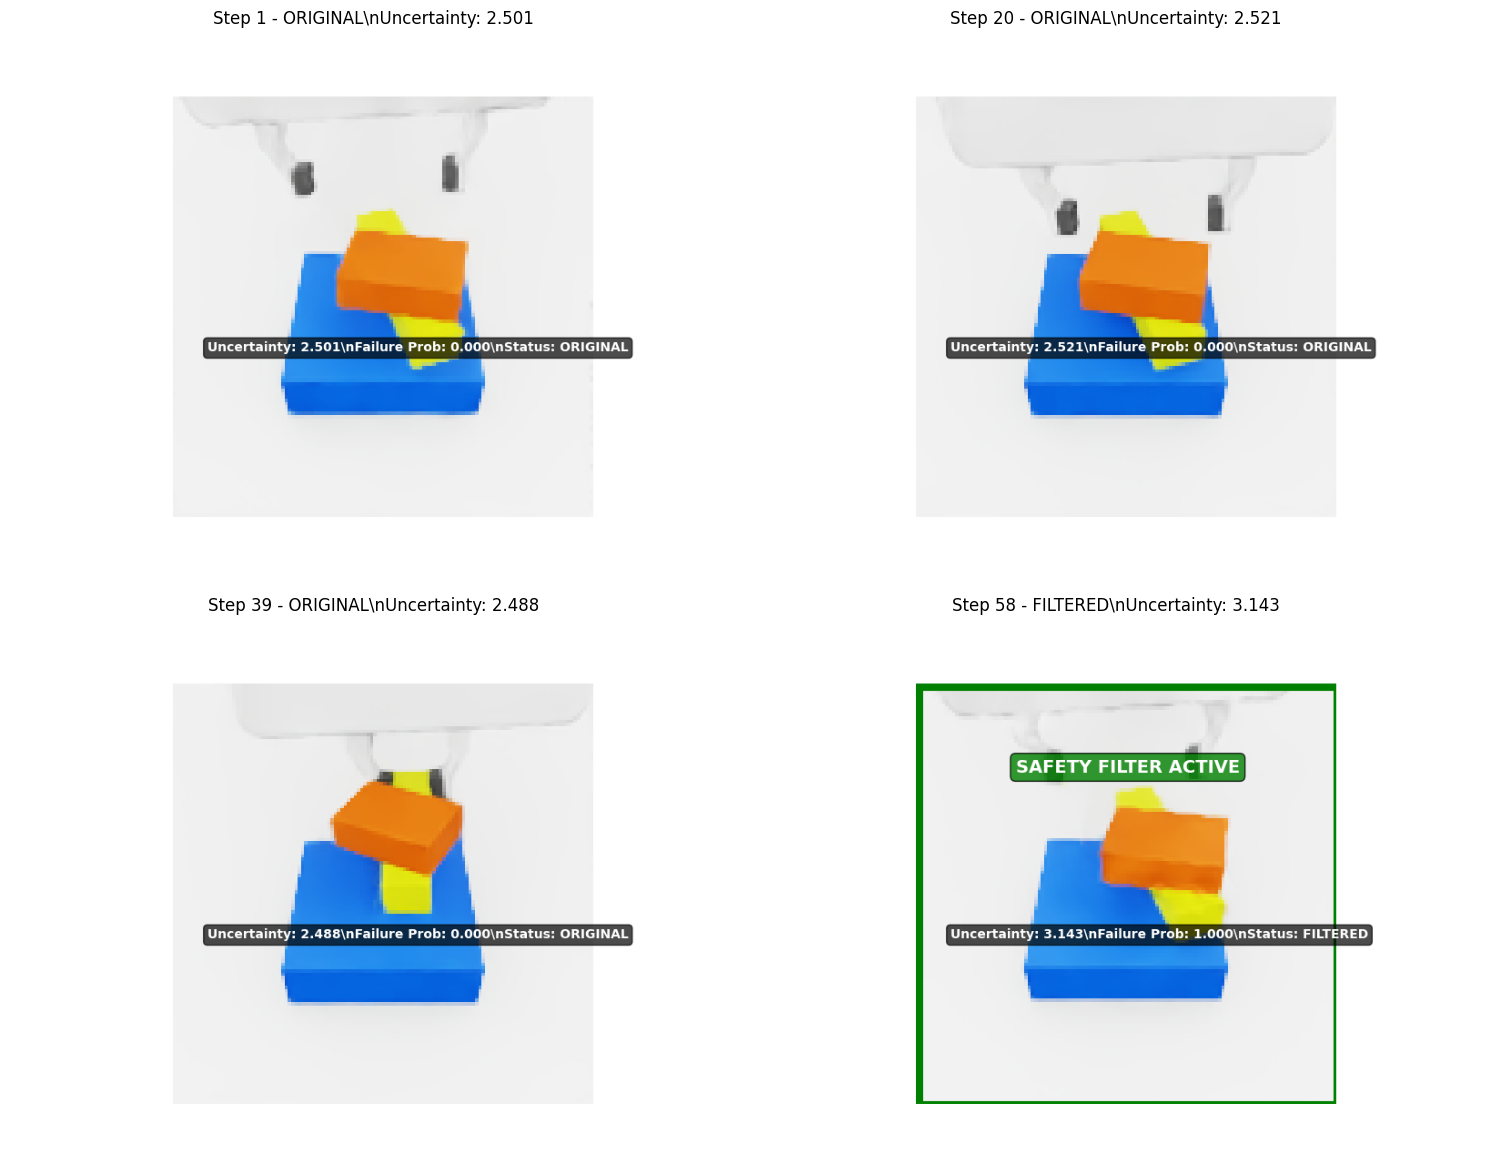

In [46]:
# Display sample frames
if demo_results['frames']:
    print("🖼️ Sample frames from the safety filtering demo:")
    
    # Show first few frames
    num_samples = min(4, len(demo_results['frames']))
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    sample_indices = np.linspace(0, len(demo_results['frames'])-1, num_samples, dtype=int)
    
    for i, idx in enumerate(sample_indices):
        frame = demo_results['frames'][idx]
        metrics = demo_results['metrics'][idx]
        
        axes[i].imshow(frame)
        status = "FILTERED" if metrics['was_filtered'] else "ORIGINAL"
        axes[i].set_title(f"Step {idx+1} - {status}\\nUncertainty: {metrics['uncertainty']:.3f}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("❌ No frames captured during demo")


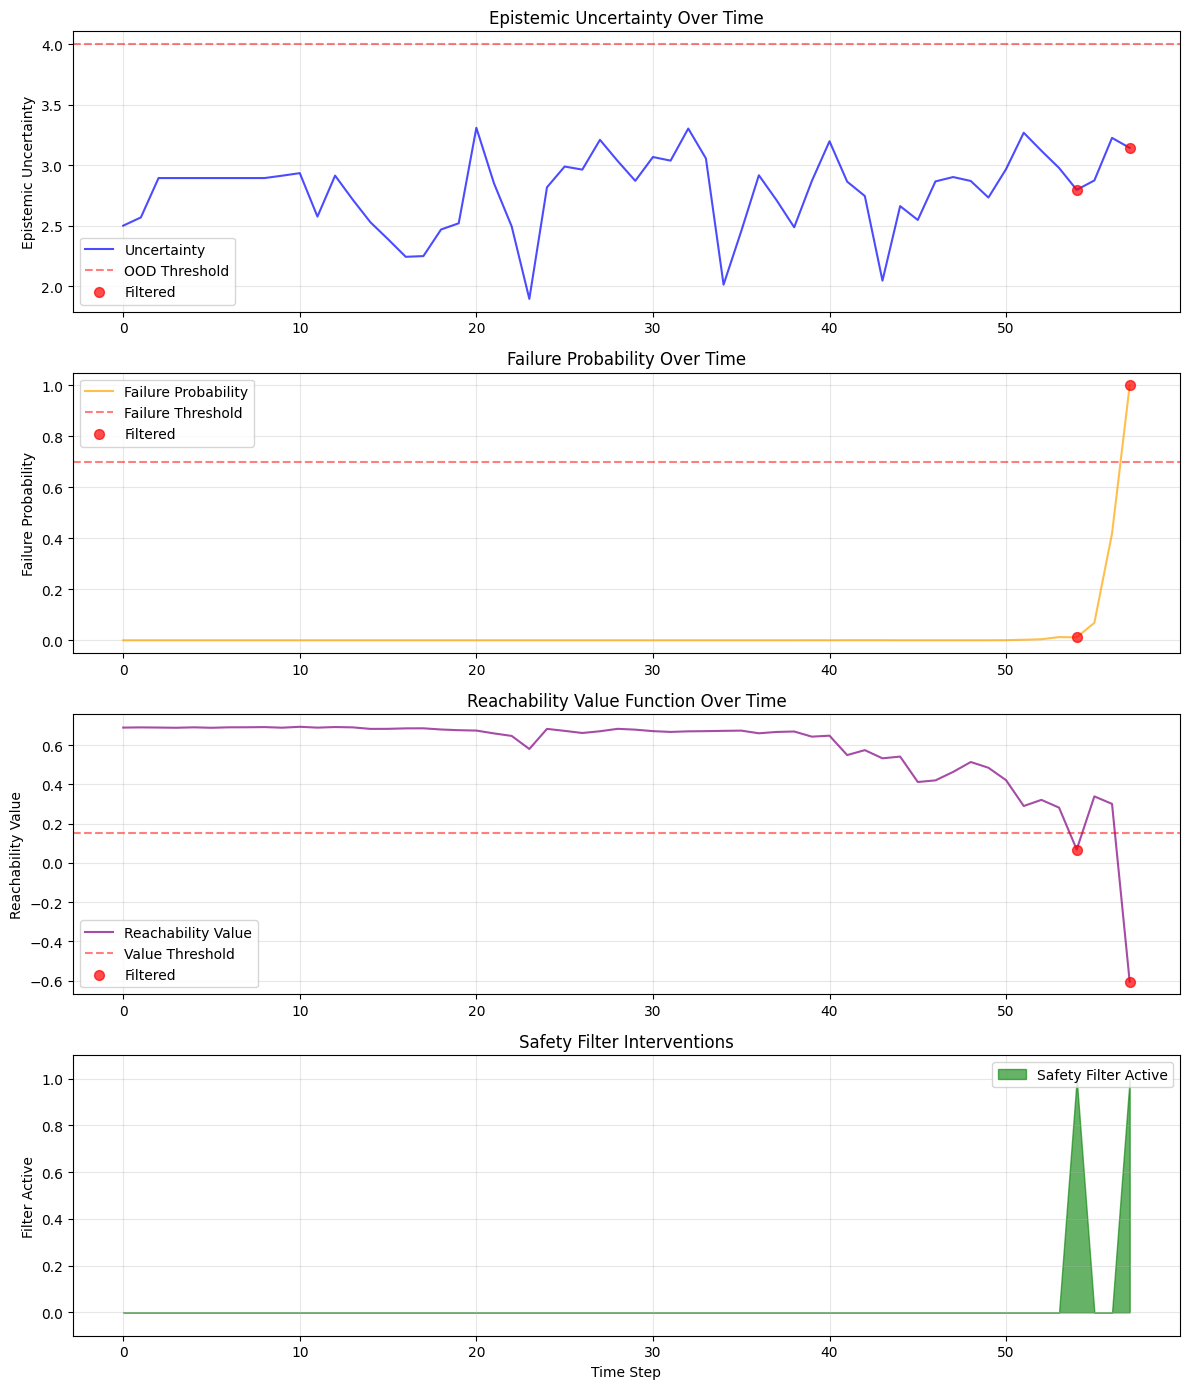

In [47]:
if demo_results['metrics']:
    # Extract metrics for analysis
    uncertainties = [m['uncertainty'] for m in demo_results['metrics']]
    failure_probs = [m['failure_prob'] for m in demo_results['metrics']]
    reachability_values = [m['reachability_value'] for m in demo_results['metrics']]
    was_filtered = [m['was_filtered'] for m in demo_results['metrics']]
    
    # Create plots
    fig, axes = plt.subplots(4, 1, figsize=(12, 14))
    
    steps = range(len(uncertainties))
    
    # Plot 1: Uncertainty over time
    axes[0].plot(steps, uncertainties, 'b-', alpha=0.7, label='Uncertainty')
    axes[0].axhline(y=config.ood_threshold, color='r', linestyle='--', alpha=0.5, label='OOD Threshold')
    
    # Highlight filtered steps
    filtered_steps = [i for i, filtered in enumerate(was_filtered) if filtered]
    if filtered_steps:
        filtered_uncertainties = [uncertainties[i] for i in filtered_steps]
        axes[0].scatter(filtered_steps, filtered_uncertainties, color='red', s=50, alpha=0.7, label='Filtered', zorder=5)
    
    axes[0].set_ylabel('Epistemic Uncertainty')
    axes[0].set_title('Epistemic Uncertainty Over Time')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Failure probability over time
    axes[1].plot(steps, failure_probs, 'orange', alpha=0.7, label='Failure Probability')
    axes[1].axhline(y=0.7, color='r', linestyle='--', alpha=0.5, label='Failure Threshold')
    
    if filtered_steps:
        filtered_failure_probs = [failure_probs[i] for i in filtered_steps]
        axes[1].scatter(filtered_steps, filtered_failure_probs, color='red', s=50, alpha=0.7, label='Filtered', zorder=5)
    
    axes[1].set_ylabel('Failure Probability')
    axes[1].set_title('Failure Probability Over Time')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Reachability Value Function over time
    axes[2].plot(steps, reachability_values, 'purple', alpha=0.7, label='Reachability Value')
    axes[2].axhline(y=0.15, color='r', linestyle='--', alpha=0.5, label='Value Threshold')
    
    if filtered_steps:
        filtered_reachability_values = [reachability_values[i] for i in filtered_steps]
        axes[2].scatter(filtered_steps, filtered_reachability_values, color='red', s=50, alpha=0.7, label='Filtered', zorder=5)
    
    axes[2].set_ylabel('Reachability Value')
    axes[2].set_title('Reachability Value Function Over Time')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    # Plot 4: Filtering decisions
    filter_decisions = [1 if filtered else 0 for filtered in was_filtered]
    axes[3].fill_between(steps, filter_decisions, alpha=0.6, color='green', label='Safety Filter Active')
    axes[3].set_ylabel('Filter Active')
    axes[3].set_xlabel('Time Step')
    axes[3].set_title('Safety Filter Interventions')
    axes[3].set_ylim(-0.1, 1.1)
    axes[3].legend()
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\\n📈 Safety Metrics Summary:")
    print(f"  Mean uncertainty: {np.mean(uncertainties):.3f} ± {np.std(uncertainties):.3f}")
    print(f"  Max uncertainty: {np.max(uncertainties):.3f}")
    print(f"  Mean failure probability: {np.mean(failure_probs):.3f} ± {np.std(failure_probs):.3f}")
    print(f"  Max failure probability: {np.max(failure_probs):.3f}")
    print(f"  Mean reachability value: {np.mean(reachability_values):.3f} ± {np.std(reachability_values):.3f}")
    print(f"  Min reachability value: {np.min(reachability_values):.3f}")
    print(f"  Filter activation rate: {np.mean(was_filtered)*100:.1f}%")
    print(f"  Steps where uncertainty > threshold: {sum(1 for u in uncertainties if u > config.ood_threshold)}")
    print(f"  Steps where failure prob > 0.7: {sum(1 for f in failure_probs if f > 0.7)}")
    print(f"  Steps where reachability value < threshold: {sum(1 for v in reachability_values if v < 0.15)}")
else:
    print("❌ No metrics available for analysis")


## Cleanup and Summary


In [48]:
## Create and Save Video

# Create video from captured frames
if demo_results['frames'] and len(demo_results['frames']) > 0:
    print("🎬 Creating video from captured frames...")
    
    # Extract metrics for video overlay
    uncertainties = [m['uncertainty'] for m in demo_results['metrics']]
    reachabilities = [m['reachability_value'] for m in demo_results['metrics']]
    failure_probs = [m['failure_prob'] for m in demo_results['metrics']]
    was_filtered = [m['was_filtered'] for m in demo_results['metrics']]
    
    # Create video with safety metrics overlay
    video_path = create_safety_video(
        frames=demo_results['frames'],
        uncertainties=uncertainties,
        reachabilities=reachabilities,
        failure_probs=failure_probs,
        is_filtered_list=was_filtered,
        save_path="latent_safety/videos/safety_filtering_demo.mp4"
    )
    
    if video_path:
        print(f"✅ Video saved successfully: {video_path}")
        
        # Display video in notebook
        print("\\n📺 Displaying video in notebook:")
        success = display_video_in_notebook(video_path)
        
        if success:
            print("✅ Video displayed successfully!")
            print(f"\\n🎯 Video shows:")
            print(f"  • {len(demo_results['frames'])} frames of the safety filtering demo")
            print(f"  • Green borders indicate when safety filter was active")
            print(f"  • Real-time safety metrics overlay")
            print(f"  • Filter activation rate: {sum(was_filtered)/len(was_filtered)*100:.1f}%")
        else:
            print("❌ Could not display video in notebook")
            print(f"📁 Video file saved at: {video_path}")
            print("You can download and play it manually")
    else:
        print("❌ Failed to create video")
else:
    print("❌ No frames available to create video")

# Clean up environment and simulation app
try:
    # Close environment
    if 'env' in globals():
        env.close()
        print("\\n✅ Environment closed successfully")
        
    # Close simulation app (prioritize notebook's app over dreamer's)
    if 'simulation_app' in globals():
        sim_app = globals()['simulation_app']
        if sim_app is not None:
            sim_app.close()
            print("✅ Notebook simulation app closed successfully")
        else:
            print("ℹ️ Notebook simulation app was None (no cleanup needed)")
    elif 'dreamer' in globals() and hasattr(dreamer, 'simulation_app') and dreamer.simulation_app is not None:
        dreamer.simulation_app.close()
        print("✅ Dreamer simulation app closed successfully")
    else:
        print("ℹ️ No simulation app found to close")
        
except Exception as e:
    print(f"⚠️ Cleanup completed with minor issues: {e}")

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("✅ GPU memory cleared")

print("\\n🎉 Safety filtering demonstration complete!")
print("\\n📋 Summary of what was demonstrated:")
print("  • Loaded pretrained world model and safety filter")
print("  • Used recorded failure episode as base policy")
print("  • Applied safety filtering to prevent unsafe actions")
print("  • Visualized results with green borders when filtering occurred")
print("  • Analyzed safety metrics over time")
print("  • Created video recording of the demonstration")
print("\\n🛡️ The safety filter successfully intervened when:")
print("  • Epistemic uncertainty was too high (model unsure about predictions)")
print("  • Failure probability exceeded threshold (explicit failure detection)")
print("\\n💡 Note: If you encountered async errors, try running this notebook")
print("     in an Isaac Lab Python environment or restart the kernel and run again.")


In [ ]:
## Watch the Video

# Display the video if it was created successfully
import os
from pathlib import Path

# Check for the latest video file
video_dir = Path("latent_safety/videos")
if video_dir.exists():
    video_files = list(video_dir.glob("safety_demo_*.mp4"))
    if video_files:
        # Get the most recent video file
        latest_video = max(video_files, key=os.path.getctime)
        
        print(f"🎬 Found video: {latest_video}")
        print("📺 Playing video...")
        
        # Display the video
        from IPython.display import Video, display
        display(Video(str(latest_video), width=800, height=600))
        
        # Also provide download link
        print(f"\\n💾 To download the video, use: {latest_video}")
        
    else:
        print("❌ No video files found in latent_safety/videos/")
        print("Please run the demo cells above first to generate the video.")
else:
    print("❌ Video directory not found")
    print("Please run the demo cells above first to generate the video.")
